In [1]:
import os, random
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Input, Dense, Dropout
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.image import rgb_to_grayscale as to_grayscale
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory as ImageGenerator
from tensorflow.python.ops.numpy_ops import np_config

from livelossplot import PlotLossesKerasTF

### Enable Numpy Behaviour
np_config.enable_numpy_behavior()

In [2]:
base_dir = 'dataset'
dir_with_mask = os.path.join(base_dir,'with_mask')
dir_without_mask = os.path.join(base_dir,'without_mask')

In [46]:
dir_with_mask[23:]
dir_without_mask[23:]

'without_mask'

In [3]:
img_height, img_width = 90,90

In [58]:
def access_images(path,show=True):
    img_path = random.choice(os.listdir(path)) ## randomly choose image path
    img_path = os.path.join(path,img_path)
    
    print("Loading Image.........")
    img = load_img(img_path,target_size=(img_height, img_width))
    print(type(img))
    
    print("Converting to Tensor (By Default RGB Format).........")
    img = img_to_array(img) #convert to tensor
    print(type(img),img.shape,img.dtype,np.min(img),np.max(img))
    
    print("Plotting Original Image.........")
    ax = plt.subplot(2,2,1)
    plt.title('Original Image - RGB')
    plt.imshow(img.astype('uint8'))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    print("Scaling (RGB)Image.........")
    img = img/255.
    print(type(img),img.shape,img.dtype,np.min(img),np.max(img))
    
    print("Plotting (RGB)Scaled Image.........")
    ax = plt.subplot(2,2,2)
    plt.title('Scaled Image - RGB')
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    print("Plotting Gray Scale Image.........")
    ax = plt.subplot(2,2,3)
    img = to_grayscale(img) #Convert to GrayScale
    plt.title('GrayScale Image')
    print("Convert to GrayScale Tensor - ",type(img),img.shape,img.dtype,np.min(img),np.max(img))
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.show()
    return img

Loading Image.........
<class 'PIL.Image.Image'>
Converting to Tensor (By Default RGB Format).........
<class 'numpy.ndarray'> (90, 90, 3) float32 0.0 255.0
Plotting Original Image.........
Scaling (RGB)Image.........
<class 'numpy.ndarray'> (90, 90, 3) float32 0.0 1.0
Plotting (RGB)Scaled Image.........
Plotting Gray Scale Image.........
Convert to GrayScale Tensor -  <class 'tensorflow.python.framework.ops.EagerTensor'> (90, 90, 1) <dtype: 'float32'> tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.99990004, shape=(), dtype=float32)


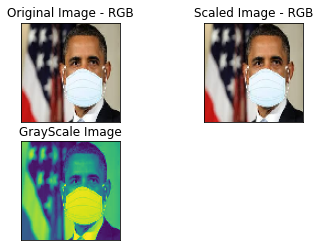

In [59]:
img = access_images(dir_with_mask)

In [6]:
print(np.min(img),np.max(img))

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.9990059, shape=(), dtype=float32)


### Create Image Generator

In [7]:
batch_size=32
(train,valid) = ImageGenerator(
                         directory=base_dir
                        ,labels='inferred'
                        ,label_mode='binary'
                        ,color_mode='grayscale'
                        ,batch_size=batch_size
                        ,image_size=(img_height, img_width)
                        ,validation_split=0.15
                        ,seed=18
                        ,subset='both'
                        )

Found 1376 files belonging to 2 classes.
Using 1170 files for training.
Using 206 files for validation.


In [8]:
print(train,'\n',train.class_names,'\n',valid.class_names)

<BatchDataset element_spec=(TensorSpec(shape=(None, 90, 90, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> 
 ['with_mask', 'without_mask'] 
 ['with_mask', 'without_mask']


In [9]:
print(train.element_spec[0].shape[1:])

(90, 90, 1)


## Bulid Model

In [10]:
model = Sequential()

model.add(Conv2D(64,(4,4),activation='relu',input_shape=train.element_spec[0].shape[1:]))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(32,(4,4),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(8,(4,4),activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(2,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(1,(3,3),activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

print('-----------------------------------------------------------')
#NUMBER OF NODES AFTER FLATTENING
nodes = model.layers[-1].output_shape[1]
print( np.ceil(np.sqrt(nodes))
      ,'\n',int(nodes/32)
      ,'\n',int(nodes/64)
      ,'\n',int(nodes/128)
      ,'\n',int(nodes/256))
print('-----------------------------------------------------------')
###----------------BEFORERUNNING NEXT CELL CHECK TRAINABLE PARAMETERS HERE, BY UNCOMMENTING BELOW LINE
model.summary()

-----------------------------------------------------------
77.0 
 185 
 92 
 46 
 23
-----------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 87, 87, 64)        1088      
                                                                 
 batch_normalization (BatchN  (None, 87, 87, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 87, 87, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 84, 32)        32800     
                                                                 
 batch_normalization_1 (Batc  (None, 84, 84, 32)       128       
 hNormalization)                          

In [11]:
model.add(Dense(int(nodes/64),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(int(nodes/128),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(int(nodes/128),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(int(nodes/256),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 87, 87, 64)        1088      
                                                                 
 batch_normalization (BatchN  (None, 87, 87, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 87, 87, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 84, 32)        32800     
                                                                 
 batch_normalization_1 (Batc  (None, 84, 84, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 84, 84, 32)        0

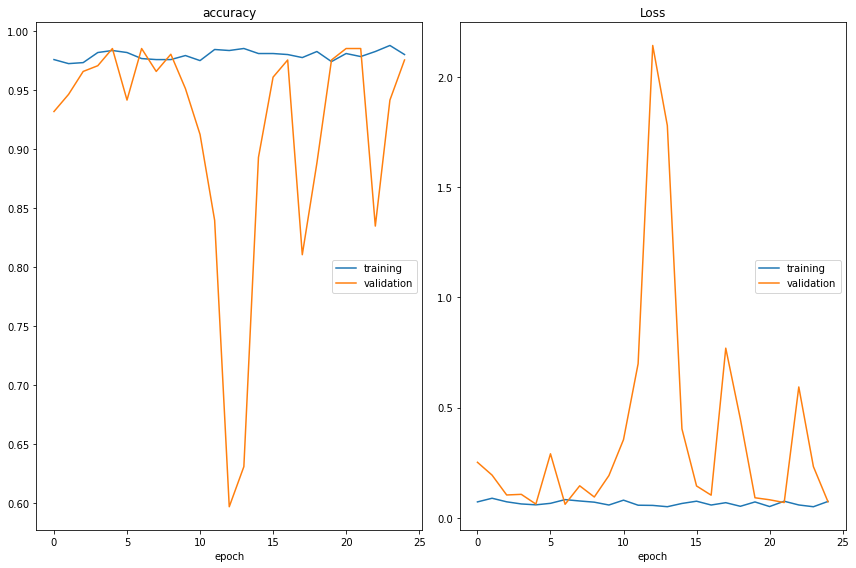

accuracy
	training         	 (min:    0.973, max:    0.988, cur:    0.980)
	validation       	 (min:    0.597, max:    0.985, cur:    0.976)
Loss
	training         	 (min:    0.051, max:    0.090, cur:    0.075)
	validation       	 (min:    0.062, max:    2.142, cur:    0.073)

37/37 [==============================] - 103s 3s/step - loss: 0.0751 - accuracy: 0.9803 - val_loss: 0.0735 - val_accuracy: 0.9757


In [14]:
epochs = 25
batch_size = 64
model.fit(train,epochs=epochs,batch_size=batch_size,validation_data=valid,callbacks=[PlotLossesKerasTF()])

In [15]:
model.save('Mask Classification.h5')

In [101]:
outcomes = {0:'With Mask',1:'Without Mask'}
def predict_target(model,data):
    Y_pred = model.predict(data)
    Y_pred = np.where(Y_pred>0.5,1,0)
    return Y_pred.flatten()

In [98]:
def get_image_for_pred(path):
    img_path = random.choice(os.listdir(path)) ## randomly choose image path
    img_path = os.path.join(path,img_path)
    
    print("Loading Image.........")
    img = load_img(img_path,target_size=(img_height, img_width))
    print(type(img))
    
    print("Converting to Tensor (By Default RGB Format).........")
    img = img_to_array(img) #convert to tensor
    print(type(img),img.shape,img.dtype,np.min(img),np.max(img))
    
    img = to_grayscale(img) #Convert to GrayScale
    
    plt.show()
    return img

### With Mask

Loading Image.........
<class 'PIL.Image.Image'>
Converting to Tensor (By Default RGB Format).........
<class 'numpy.ndarray'> (90, 90, 3) float32 0.0 255.0
(90, 90, 1)
(1, 90, 90, 1)
1/1 [==============================] - 0s 75ms/step
0


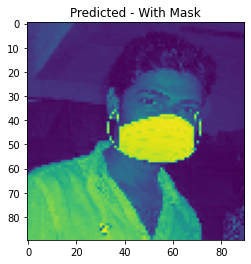

In [106]:
img = get_image_for_pred(dir_with_mask)
print(img.shape)
img = img.reshape(((1,)+img.shape))
print(img.shape)
Y_pred = predict_target(model,img.reshape(1,90,90,1))
print(Y_pred[0])
plt.title('Predicted - '+outcomes[Y_pred[0]])
plt.imshow(img.reshape(img.shape[1:]))

### Without Mask

Loading Image.........
<class 'PIL.Image.Image'>
Converting to Tensor (By Default RGB Format).........
<class 'numpy.ndarray'> (90, 90, 3) float32 0.0 255.0
(90, 90, 1)
(1, 90, 90, 1)
1/1 [==============================] - 0s 60ms/step
1


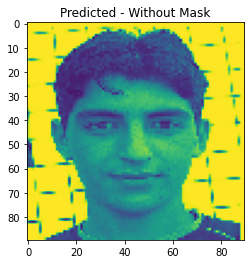

In [105]:
img = get_image_for_pred(dir_without_mask)
print(img.shape)
img = img.reshape(((1,)+img.shape))
print(img.shape)
Y_pred = predict_target(model,img.reshape(1,90,90,1))
print(Y_pred[0])
plt.title('Predicted - '+outcomes[Y_pred[0]])
plt.imshow(img.reshape(img.shape[1:]))
plt.show()